In [18]:
# Importation des bibliotheques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
!pip install openpyxl
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
# Charger les donnees et vérification des premieres lignes
df= pd.read_excel(r"C:\Users\PC\Desktop\PFE\masi.xlsx")
print(df.head())

      Seance     MASI
0 2001-01-02  3995.23
1 2001-01-03  3976.85
2 2001-01-04  3956.23
3 2001-01-05  3898.17
4 2001-01-08  3870.26


In [4]:
# 1. Types de données
print("Types de données :\n", df.dtypes, "\n")

Types de données :
 Seance    datetime64[ns]
MASI             float64
dtype: object 



In [5]:
# 2. Valeurs manquantes
print("Valeurs manquantes :\n", df.isnull().sum(), "\n")

Valeurs manquantes :
 Seance    0
MASI      0
dtype: int64 



In [6]:
# 3. Doublons de dates
print("Doublons dans la colonne 'Seance' :", df["Seance"].duplicated().sum(), "\n")

Doublons dans la colonne 'Seance' : 0 



In [7]:
# 5. Statistiques descriptives de la colonne MASI
print("Statistiques descriptives de MASI :\n", df["MASI"].describe(), "\n")

Statistiques descriptives de MASI :
 count     6045.000000
mean      9696.880177
std       3346.982060
min       2786.440000
25%       8680.700000
50%      10638.780000
75%      12011.590000
max      17858.900000
Name: MASI, dtype: float64 



In [8]:
#Nombre de lignes 
print("Le nombre de ligne est de :\n" , len(df), "\n")

Le nombre de ligne est de :
 6045 



In [9]:
# Calcul de la variation quotidienne en pourcentage
df['Return (%)'] = df['MASI'].pct_change() * 100

# Afficher les 10 premières lignes avec variation
print(df.head(10))

      Seance     MASI  Return (%)
0 2001-01-02  3995.23         NaN
1 2001-01-03  3976.85   -0.460049
2 2001-01-04  3956.23   -0.518501
3 2001-01-05  3898.17   -1.467559
4 2001-01-08  3870.26   -0.715977
5 2001-01-09  3838.59   -0.818291
6 2001-01-10  3817.77   -0.542387
7 2001-01-12  3778.91   -1.017872
8 2001-01-15  3765.80   -0.346925
9 2001-01-16  3775.34    0.253333


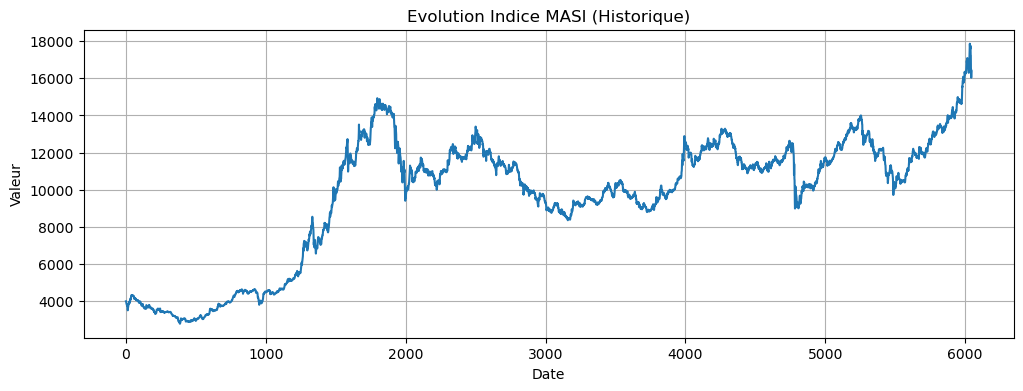

In [10]:
# Tracer l’évolution de l’indice MASI
plt.figure(figsize=(12, 4))
plt.plot(df['MASI'])
plt.title("Evolution Indice MASI (Historique)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


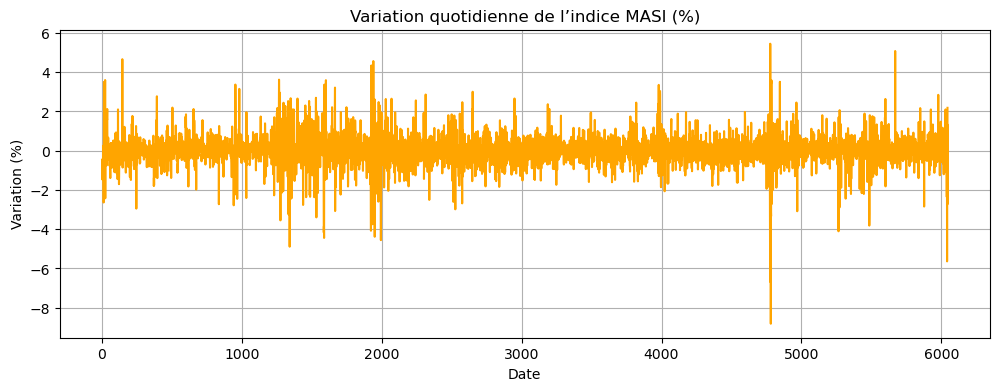

In [57]:
# Tracer la variation quotidienne
plt.figure(figsize=(12, 4))
plt.plot(df['Return (%)'], color='orange')
plt.title("Variation quotidienne de l’indice MASI (%)")
plt.xlabel("Date")
plt.ylabel("Variation (%)")
plt.grid(True)
plt.show()

Le test de stationnarité ADF (Augmented Dickey-Fuller) nous permet de vérifier si la série Return (%) est stationnaire, c’est-à-dire si ses propriétés statistiques (moyenne, variance) restent constantes dans le temps.

**Objectif du test ADF**
H0 (hypothèse nulle) : la série n’est pas stationnaire
H1 (hypothèse alternative) : la série est stationnaire 
Si la p-value < 0.05, on rejette H0 → la série est stationnaire

In [21]:
# Extraire la série
series = df["MASI"]

#Test ADF
adf_result = adfuller(series, autolag='AIC')
print("### Test ADF (Augmented Dickey-Fuller) ###")
print(f"Statistique ADF : {adf_result[0]}")
print(f"p-value : {adf_result[1]}")
print("Valeurs critiques :")
for key, value in adf_result[4].items():
    print(f"   {key} : {value}")
if adf_result[1] < 0.05:
    print("=> La série est probablement stationnaire (H₀ rejetée)")
else:
    print("=> La série n'est pas stationnaire (H₀ non rejetée)")

### Test ADF (Augmented Dickey-Fuller) ###
Statistique ADF : -0.8727030773402424
p-value : 0.7968287437537163
Valeurs critiques :
   1% : -3.4314329466736715
   5% : -2.8620185634786486
   10% : -2.5670247367967622
=> La série n'est pas stationnaire (H₀ non rejetée)


In [14]:
# ----- Test KPSS -----
kpss_result = kpss(series, regression='c', nlags='auto')
print("\n### Test KPSS ###")
print(f"Statistique KPSS : {kpss_result[0]}")
print(f"p-value : {kpss_result[1]}")
print("Valeurs critiques :")
for key, value in kpss_result[3].items():
    print(f"   {key} : {value}")
if kpss_result[1] < 0.05:
    print("=> La série n'est pas stationnaire (H₀ rejetée)")
else:
    print("=> La série est probablement stationnaire (H₀ non rejetée)")


### Test KPSS ###
Statistique KPSS : 7.334179624663005
p-value : 0.01
Valeurs critiques :
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
=> La série n'est pas stationnaire (H₀ rejetée)


C:\Users\PC\AppData\Local\Temp\ipykernel_14476\3438420940.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


<Figure size 1000x400 with 0 Axes>

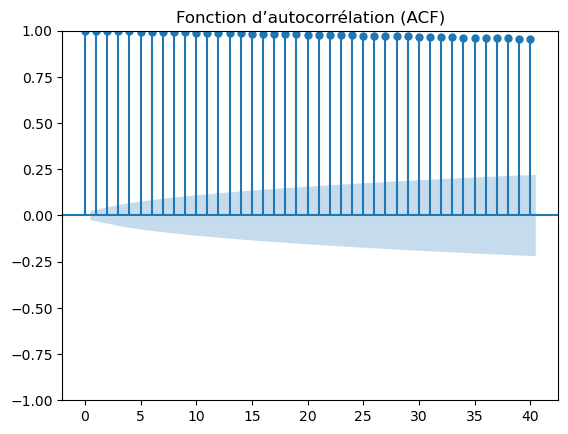

In [15]:
# Test ACF
plt.figure(figsize=(10, 4))
plot_acf(series, lags=40)
plt.title('Fonction d’autocorrélation (ACF)')
plt.show()

<Figure size 1000x400 with 0 Axes>

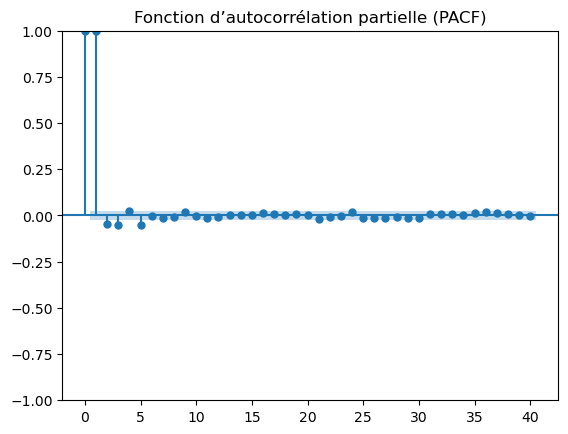

In [17]:
# Test PACF
plt.figure(figsize=(10, 4))
plot_pacf(series, lags=40, method='ywm')
plt.title('Fonction d’autocorrélation partielle (PACF)')
plt.show()

L’analyse de la fonction d’autocorrélation (ACF) montre une décroissance lente, traduisant une forte dépendance entre les observations successives du MASI. La PACF, quant à elle, suggère une structure autorégressive de faible ordre (AR(2)). Ces résultats confirment la non-stationnarité de la série, déjà mise en évidence par les tests ADF et KPSS. Une différenciation s’impose avant toute modélisation classique. Toutefois, dans le cadre de ce projet, nous poursuivrons avec des approches de deep learning, plus tolérantes à la non-stationnarité.

Prochaine étape : préparation des données pour LSTM

In [20]:
masi_series=df[['MASI']].values

In [23]:
# Normalisation des données entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
masi_scaled = scaler.fit_transform(masi_series)

# Création des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Longueur de la séquence 
sequence_length = 60
X, y = create_sequences(masi_scaled, sequence_length)

# Vérification des formes obtenues
X.shape, y.shape

# Reshape pour LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Afficher les formes des jeux de données préparés
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4788, 60, 1), (1197, 60, 1), (4788, 1), (1197, 1))

In [24]:
# Définition du modèle
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))  # Prédiction d'une seule valeur

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30


C:\Users\PC\anaconda3\envs\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0267 - val_loss: 2.0805e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7630e-04 - val_loss: 2.1827e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7024e-04 - val_loss: 2.1391e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.4534e-04 - val_loss: 2.3692e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2824e-04 - val_loss: 1.7619e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.4226e-04 - val_loss: 1.8868e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.2892e-04 - val_loss: 1.9564e-04
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.2012e-04 - val_loss: 1.4165e-04
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.0985e-04 - val_loss: 1.3764e-04
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1864e-04 - val_loss: 1.2543e-04
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.

In [26]:
#mise en place du earlystoppingpour eviter le surapprentissage
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=100,  # ou plus
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.6398e-05 - val_loss: 4.8936e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.4735e-05 - val_loss: 7.9588e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8599e-05 - val_loss: 4.7928e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2218e-05 - val_loss: 1.5362e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2714e-05 - val_loss: 8.2206e-05
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4390e-05 - val_loss: 5.4416e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.7868e-05 - val_loss: 5.8632e-05
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.8967e-05 - val_loss: 8.4126e-05


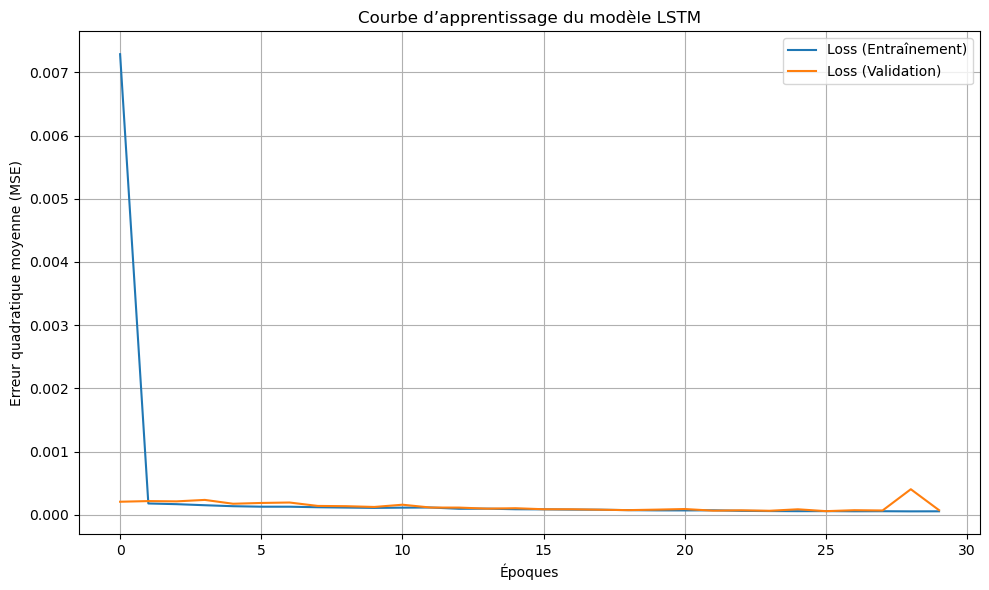

In [27]:
# Tracer la courbe loss/val_loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Courbe d’apprentissage du modèle LSTM')
plt.xlabel('Époques')
plt.ylabel('Erreur quadratique moyenne (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La courbe d’apprentissage montre une convergence très rapide du modèle dès les premières itérations, avec une stabilité remarquable de la perte sur l’ensemble de validation. La proximité entre la loss (entraînement) et la val_loss (validation) indique que le modèle généralise bien sans overfitting majeur. Une légère hausse en fin d’entraînement confirme la pertinence de l’arrêt précoce (EarlyStopping), qui permet de conserver les poids optimaux.

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


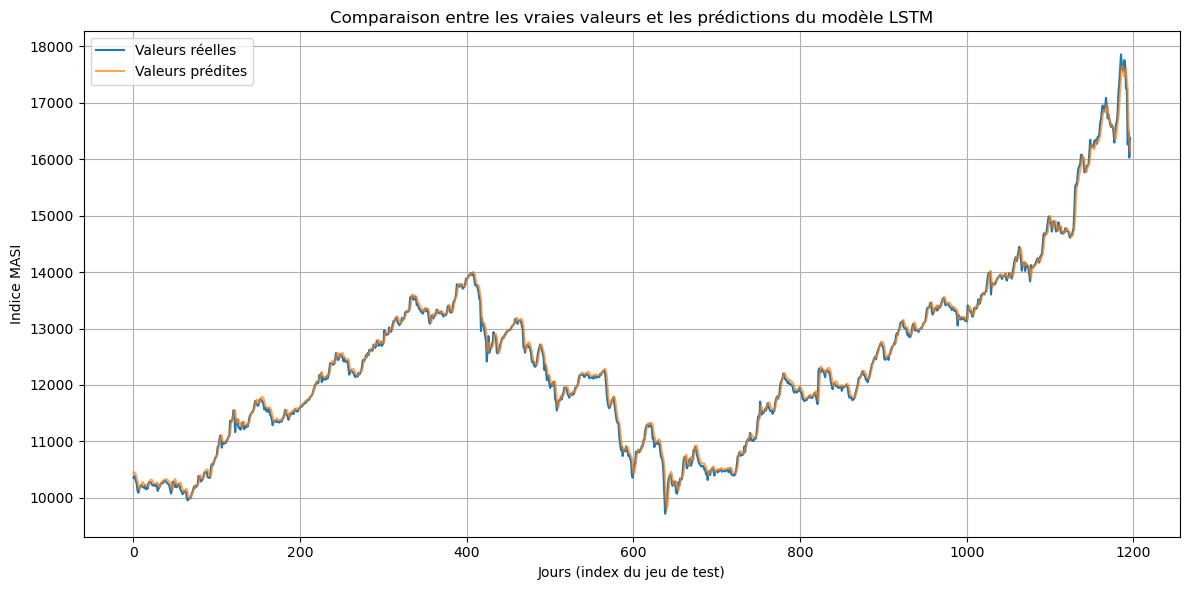

In [28]:
# Prédictions sur le jeu de test
y_pred_scaled = model.predict(X_test)

# Désnormalisation (attention à la forme)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_real = scaler.inverse_transform(y_test)

# Tracer les prédictions vs vraies valeurs
plt.figure(figsize=(12, 6))
plt.plot(y_real, label='Valeurs réelles')
plt.plot(y_pred, label='Valeurs prédites', alpha=0.7)
plt.title('Comparaison entre les vraies valeurs et les prédictions du modèle LSTM')
plt.xlabel('Jours (index du jeu de test)')
plt.ylabel('Indice MASI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Le modèle LSTM démontre une capacité remarquable à capturer l’évolution temporelle de l’indice MASI. Les courbes des valeurs réelles et prédites se superposent quasi parfaitement, même dans les phases de forte volatilité ou de retournement. Cela indique que le réseau a su apprendre les dynamiques historiques avec une grande fidélité, renforçant la pertinence des LSTM dans la prévision boursière.

In [29]:
# Prédiction sur X_test
y_pred_scaled = model.predict(X_test)

# Désnormalisation
y_pred = scaler.inverse_transform(y_pred_scaled)
y_real = scaler.inverse_transform(y_test)

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)

print(f"RMSE (Root Mean Squared Error) : {rmse:.2f}")
print(f"MAE (Mean Absolute Error)       : {mae:.2f}")
print(f"R² (Coefficient de détermination): {r2:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE (Root Mean Squared Error) : 104.35
MAE (Mean Absolute Error)       : 69.94
R² (Coefficient de détermination): 0.9956


Le modèle LSTM développé dans le cadre de ce projet a démontré une très forte capacité prédictive quant à l’évolution de l’indice MASI. L’analyse visuelle montre une superposition quasi parfaite entre les courbes des valeurs réelles et prédites, traduisant la précision du modèle dans la reproduction des tendances du marché, y compris dans les phases de volatilité.

Les performances quantitatives viennent appuyer cette observation :

RMSE (Root Mean Squared Error) : 104.35
→ Cela signifie que l’écart-type moyen entre les valeurs prédites et les valeurs réelles est très faible au regard des niveaux du MASI (compris entre ~10 000 et 18 000).

MAE (Mean Absolute Error) : 69.94
→ L’erreur absolue moyenne est inférieure à 70 points, ce qui représente moins de 0.6 % d’erreur relative sur une base de 12 000 points en moyenne.

R² (Coefficient de détermination) : 0.9956
→ Ce score exceptionnel indique que 99.56 % de la variance du MASI est expliquée par le modèle, ce qui confirme la très bonne adéquation entre les données et la modélisation.


In [32]:
#Sauvegarde du modele
model.save("modele_masi.keras")


In [33]:
# Sauvegarde du scaler utilisé pour normaliser MASI
joblib.dump(scaler, "scaler_masi.pkl")


['scaler_masi.pkl']